In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(6447) #Last 4 digits of my emailID
tf.random.set_seed(6447) #Last 4 digits of my emailID

In [28]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_val = x_train[50000:60000]
x_train = x_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]
x_train = x_train.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_val = x_val.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_test = x_test.astype(np.float32).reshape(-1,28,28,1) / 255.0
y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset_full = train_dataset.shuffle(buffer_size=1024).batch(len(train_dataset))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)
print(len(train_dataset))
print(len(test_dataset))

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
391
79


In [30]:
class BatchNorm(tf.keras.layers.Layer):
    def __init__(self, dim, epsilon=1e-4, momentum=0.99):
        super(BatchNorm, self).__init__()

        self.epsilon = epsilon
        self.momentum = momentum
        self.dim = dim

        self.it_call = 0
        self.batch_size = 0

        self.mu = self.add_weight("mu", shape=[self.dim,], 
                                initializer="zeros",
                                trainable=False)
        self.var = self.add_weight("var", shape=[self.dim,], 
                                   initializer="zeros",
                                   trainable=False)

        self.gamma = self.add_weight("gamma", shape=[1, self.dim],
                                     initializer="random_normal",
                                     trainable=True)
        self.beta = self.add_weight("beta", shape=[1, self.dim],
                                    initializer="random_normal",
                                    trainable=True)
        
    
    def call(self, inputs, is_training):
        """ Ankur Mali's pdf states the formula of BN(x) as:
        IntermediateOP(x) = (x - mean) / sqrt(variance + epsilon)
        BN(x) = gamma * IntermediateOP(x) + beta
        """

        self.it_call += 1

        if is_training:   # is_training == True: The model is in training mode, calculate batch mean and variance 
            if self.batch_size == 0:
                self.batch_size = inputs.shape[0]
            
            batch_mu = tf.math.reduce_mean(inputs, axis=(0,1,2))
            batch_var = tf.math.reduce_variance(inputs, axis=(0,1,2))
            
            normalized_inputs = tf.math.divide((inputs - batch_mu), tf.math.sqrt(batch_var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta

            # update mu and var
            if inputs.shape[0] == self.batch_size:
                running_mu = batch_mu
                running_var = batch_var
            else:
                # the last batch in training may have sample less than batch size
                running_mu = batch_mu / inputs.shape[0] * self.batch_size
                running_var = batch_var / inputs.shape[0] * self.batch_size
            
            cur_mu = running_mu * (self.momentum / self.it_call) + self.mu * (1 - (self.momentum/self.it_call))
            self.mu.assign(cur_mu)
            cur_var = running_var * (self.momentum / self.it_call) + self.var * (1 - (self.momentum/self.it_call))
            self.var.assign(cur_var)


        else: # is_training == False. The model is in testing mode, calculate population mean and variance.
            normalized_inputs = tf.math.divide((inputs - self.mu), tf.math.sqrt(self.var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta
        
        return bn_inputs

##**Model 1: Performing Batch Normalization After RELU**

In [46]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.BatchNorm=BatchNorm(64)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        # self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.acc = tf.keras.metrics.Accuracy()


    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
                         


        """
        x = self.conv1(images)


        # Layer 1:
        x = tf.nn.relu(x)
        x=self.BatchNorm(x,training)
        x = self.pool1(x)
        x = self.conv2(x)
      
        # Layer 2:
        x = tf.nn.relu(x)
        x=self.BatchNorm(x,training)
        x = self.pool1(x)
        x = self.conv3(x)

        #Layer 3:
        x = tf.nn.relu(x)
        x=self.BatchNorm(x,training)
        x = self.pool1(x)
        x = self.conv4(x)

        # Layer 4:
        x = tf.nn.relu(x)
        x=self.BatchNorm(x,training)
        x = self.pool1(x)
        x = self.conv8(x)


        x = tf.reshape(x, (-1, 1, 10)) # Shape mismatch error if x has a shape of 128. We need to reshape it to 10 (# of O/P class = 10)

        return x



    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=True)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    

    def compute_accuracy(self, images, targets,isittraining):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=isittraining)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

  
    def fit_fc(self, training_data, eval_data, optimizer, isittraining, num_epochs=500, early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, isittraining)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, isittraining)
                    accuracy = self.compute_accuracy(images,target,isittraining)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, isittraining)
                    accuracy = self.compute_accuracy(images,target,isittraining)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

In [47]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = '/content/sample_data/model_checkpoint'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

**First Run : Let's train the model**

In [33]:
# Train and Test model
isittraining = True
acc_test = tf.keras.metrics.Mean('test_acc')

seeds = np.random.randint(12,45,3)
test_accuracy = []

# for i in seeds:
  # Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)
# print('Trial on random seed:',i)
model.fit_fc(train_dataset, val_dataset, optimizer, isittraining, num_epochs=20, 
          early_stopping_rounds=2, verbose=1, train_from_scratch=True)

# Compute the loss on the eval data after one epoch
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()


Train loss at epoch 1:  1.1803046
Train Acc at epoch 1:  0.80632997
Eval loss at epoch 1:  1.1870629
Eval Acc at epoch 1:  0.8076777
Train loss at epoch 2:  0.63364905
Train Acc at epoch 2:  0.8215807
Eval loss at epoch 2:  0.645364
Eval Acc at epoch 2:  0.83175516
Train loss at epoch 3:  0.42702672
Train Acc at epoch 3:  0.8415694
Eval loss at epoch 3:  0.44613433
Eval Acc at epoch 3:  0.84954536
Train loss at epoch 4:  0.33365503
Train Acc at epoch 4:  0.8565586
Eval loss at epoch 4:  0.35934246
Eval Acc at epoch 4:  0.8626743
Train loss at epoch 5:  0.28729144
Train Acc at epoch 5:  0.86763483
Eval loss at epoch 5:  0.31999052
Eval Acc at epoch 5:  0.87211597
Train loss at epoch 6:  0.25234586
Train Acc at epoch 6:  0.8760852
Eval loss at epoch 6:  0.2928133
Eval Acc at epoch 6:  0.8797713
Train loss at epoch 7:  0.228074
Train Acc at epoch 7:  0.8830151
Eval loss at epoch 7:  0.27508155
Eval Acc at epoch 7:  0.8861132
Train loss at epoch 8:  0.21002781
Train Acc at epoch 8:  0.8888

The model stops converging at Epoch 13. [Early Stopping comes into play here]


Final Validation Acc: 0.9103

**Let's test the model and check the test accuracy**

In [35]:
isittraining = False
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()

In [36]:
test_mean = np.mean(test_accuracy)

In [37]:
test_mean

0.90808415

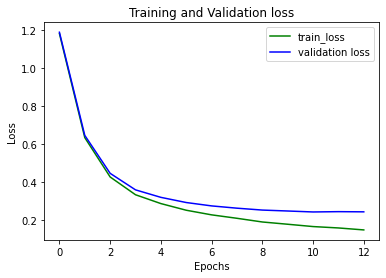

In [38]:

loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Second Run : Let's train the model**

In [48]:
# Train and Test model
isittraining = True
acc_test = tf.keras.metrics.Mean('test_acc')

seeds = np.random.randint(12,45,3)
test_accuracy = []

# for i in seeds:
  # Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)
# print('Trial on random seed:',i)
model.fit_fc(train_dataset, val_dataset, optimizer, isittraining, num_epochs=20, 
          early_stopping_rounds=2, verbose=1, train_from_scratch=True)

# Compute the loss on the eval data after one epoch
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()


Train loss at epoch 1:  1.2118716
Train Acc at epoch 1:  0.8092149
Eval loss at epoch 1:  1.2165918
Eval Acc at epoch 1:  0.80973893
Train loss at epoch 2:  0.6435711
Train Acc at epoch 2:  0.8243849
Eval loss at epoch 2:  0.65477705
Eval Acc at epoch 2:  0.8356071
Train loss at epoch 3:  0.4256183
Train Acc at epoch 3:  0.84516937
Eval loss at epoch 3:  0.44119614
Eval Acc at epoch 3:  0.85308605
Train loss at epoch 4:  0.33543035
Train Acc at epoch 4:  0.85968673
Eval loss at epoch 4:  0.35692707
Eval Acc at epoch 4:  0.86535376
Train loss at epoch 5:  0.28772736
Train Acc at epoch 5:  0.87000364
Eval loss at epoch 5:  0.31525826
Eval Acc at epoch 5:  0.8742022
Train loss at epoch 6:  0.25595278
Train Acc at epoch 6:  0.87783974
Eval loss at epoch 6:  0.29137748
Eval Acc at epoch 6:  0.88127774
Train loss at epoch 7:  0.22802193
Train Acc at epoch 7:  0.8842828
Eval loss at epoch 7:  0.26948914
Eval Acc at epoch 7:  0.88725656
Train loss at epoch 8:  0.2101856
Train Acc at epoch 8:  

The model stops converging at Epoch 15. [Early Stopping comes into play here]


Final Validation Acc: 0.9155



**Let's test the model and check the test accuracy**

In [49]:
isittraining = False
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()

In [50]:
test_mean = np.mean(test_accuracy)

In [51]:
test_mean

0.9130197

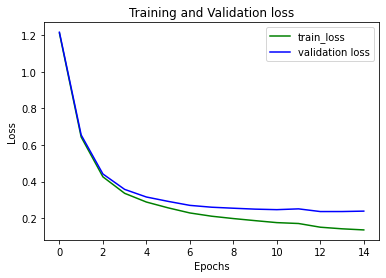

In [52]:

loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Third Run : Let's train the model**

In [53]:
# Train and Test model
isittraining = True
acc_test = tf.keras.metrics.Mean('test_acc')

seeds = np.random.randint(12,45,3)
test_accuracy = []

# for i in seeds:
  # Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)
# print('Trial on random seed:',i)
model.fit_fc(train_dataset, val_dataset, optimizer, isittraining, num_epochs=20, 
          early_stopping_rounds=2, verbose=1, train_from_scratch=True)

# Compute the loss on the eval data after one epoch
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()


Train loss at epoch 1:  0.5317939
Train Acc at epoch 1:  0.86808217
Eval loss at epoch 1:  0.54148966
Eval Acc at epoch 1:  0.8691101
Train loss at epoch 2:  0.3552261
Train Acc at epoch 2:  0.8757179
Eval loss at epoch 2:  0.37249634
Eval Acc at epoch 2:  0.88118464
Train loss at epoch 3:  0.2921354
Train Acc at epoch 3:  0.885631
Eval loss at epoch 3:  0.31600398
Eval Acc at epoch 3:  0.8894253
Train loss at epoch 4:  0.25589758
Train Acc at epoch 4:  0.89294434
Eval loss at epoch 4:  0.2873597
Eval Acc at epoch 4:  0.8960464
Train loss at epoch 5:  0.2387591
Train Acc at epoch 5:  0.898411
Eval loss at epoch 5:  0.27907115
Eval Acc at epoch 5:  0.9005812
Train loss at epoch 6:  0.21657899
Train Acc at epoch 6:  0.90275663
Eval loss at epoch 6:  0.26291722
Eval Acc at epoch 6:  0.9049333
Train loss at epoch 7:  0.20153303
Train Acc at epoch 7:  0.9067088
Eval loss at epoch 7:  0.25668195
Eval Acc at epoch 7:  0.90844303
Train loss at epoch 8:  0.18888746
Train Acc at epoch 8:  0.9099

The model stops converging at Epoch 13. [Early Stopping comes into play here]


Final Validation Acc: 0.9234

**Let's test the model and check the test accuracy**

In [54]:
isittraining = False
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()

In [55]:
test_mean = np.mean(test_accuracy)

In [56]:
test_mean

0.9205788

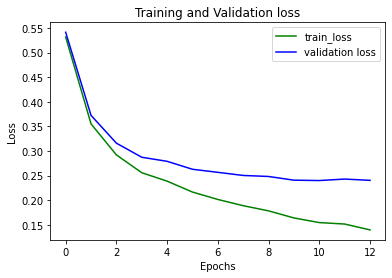

In [57]:

loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##**Model 2: Performing Batch Normalization Before RELU**

In [58]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.BatchNorm=BatchNorm(64)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        # self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.acc = tf.keras.metrics.Accuracy()


    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
                         


        """
        x = self.conv1(images)


        # Layer 1:
        x=self.BatchNorm(x,training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
      
        # Layer 2:
        x=self.BatchNorm(x,training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)

        #Layer 3:
        x=self.BatchNorm(x,training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv4(x)

        # Layer 4:
        x=self.BatchNorm(x,training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv8(x)


        x = tf.reshape(x, (-1, 1, 10)) # Shape mismatch error if x has a shape of 128. We need to reshape it to 10 (# of O/P class = 10)

        return x



    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=True)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    

    def compute_accuracy(self, images, targets,isittraining):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=isittraining)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

  
    def fit_fc(self, training_data, eval_data, optimizer, isittraining, num_epochs=500, early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, isittraining)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, isittraining)
                    accuracy = self.compute_accuracy(images,target,isittraining)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, isittraining)
                    accuracy = self.compute_accuracy(images,target,isittraining)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

In [59]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = '/content/sample_data/model_checkpoint'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

**First Run : Let's train the model**

In [41]:
# Train and Test model
isittraining = True
acc_test = tf.keras.metrics.Mean('test_acc')

seeds = np.random.randint(12,45,3)
test_accuracy = []

# for i in seeds:
  # Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)
# print('Trial on random seed:',i)
model.fit_fc(train_dataset, val_dataset, optimizer, isittraining, num_epochs=20, 
          early_stopping_rounds=2, verbose=1, train_from_scratch=True)

# Compute the loss on the eval data after one epoch
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()


Train loss at epoch 1:  1.307168
Train Acc at epoch 1:  0.78399485
Eval loss at epoch 1:  1.3099757
Eval Acc at epoch 1:  0.7839352
Train loss at epoch 2:  0.74071014
Train Acc at epoch 2:  0.7976061
Eval loss at epoch 2:  0.74767375
Eval Acc at epoch 2:  0.8080212
Train loss at epoch 3:  0.5066269
Train Acc at epoch 3:  0.81870013
Eval loss at epoch 3:  0.51763153
Eval Acc at epoch 3:  0.8276493
Train loss at epoch 4:  0.3984075
Train Acc at epoch 4:  0.8351403
Eval loss at epoch 4:  0.41292173
Eval Acc at epoch 4:  0.8415396
Train loss at epoch 5:  0.33940515
Train Acc at epoch 5:  0.84706485
Eval loss at epoch 5:  0.35783175
Eval Acc at epoch 5:  0.8520956
Train loss at epoch 6:  0.2975651
Train Acc at epoch 6:  0.8566461
Eval loss at epoch 6:  0.32075936
Eval Acc at epoch 6:  0.86074644
Train loss at epoch 7:  0.2668177
Train Acc at epoch 7:  0.8645068
Eval loss at epoch 7:  0.2929819
Eval Acc at epoch 7:  0.8680806
Train loss at epoch 8:  0.24774356
Train Acc at epoch 8:  0.871281

**Let's test the model**

In [42]:
isittraining = False
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()

In [43]:
test_mean = np.mean(test_accuracy)

In [44]:
test_mean

0.9110058

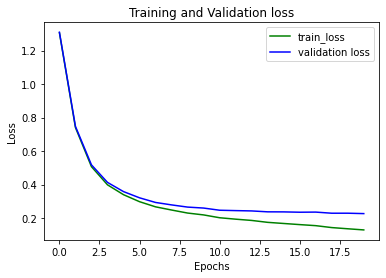

In [45]:

loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Second Run : Let's train the model**

In [60]:
# Train and Test model
isittraining = True
acc_test = tf.keras.metrics.Mean('test_acc')

seeds = np.random.randint(12,45,3)
test_accuracy = []

# for i in seeds:
  # Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)
# print('Trial on random seed:',i)
model.fit_fc(train_dataset, val_dataset, optimizer, isittraining, num_epochs=20, 
          early_stopping_rounds=2, verbose=1, train_from_scratch=True)

# Compute the loss on the eval data after one epoch
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()


Train loss at epoch 1:  1.2706825
Train Acc at epoch 1:  0.7761666
Eval loss at epoch 1:  1.2730173
Eval Acc at epoch 1:  0.7774605
Train loss at epoch 2:  0.7305022
Train Acc at epoch 2:  0.79378486
Eval loss at epoch 2:  0.7363998
Eval Acc at epoch 2:  0.80617577
Train loss at epoch 3:  0.5013961
Train Acc at epoch 3:  0.81756413
Eval loss at epoch 3:  0.512344
Eval Acc at epoch 3:  0.82692486
Train loss at epoch 4:  0.39496726
Train Acc at epoch 4:  0.83482575
Eval loss at epoch 4:  0.4102286
Eval Acc at epoch 4:  0.84181124
Train loss at epoch 5:  0.33416712
Train Acc at epoch 5:  0.84787333
Eval loss at epoch 5:  0.3533603
Eval Acc at epoch 5:  0.8531874
Train loss at epoch 6:  0.29283902
Train Acc at epoch 6:  0.857839
Eval loss at epoch 6:  0.31489357
Eval Acc at epoch 6:  0.8621456
Train loss at epoch 7:  0.2675573
Train Acc at epoch 7:  0.86585474
Eval loss at epoch 7:  0.29497507
Eval Acc at epoch 7:  0.86933243
Train loss at epoch 8:  0.24812518
Train Acc at epoch 8:  0.8724

**Let's test the model**

In [61]:
isittraining = False
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()

In [62]:
test_mean = np.mean(test_accuracy)

In [63]:
test_mean

0.91278327

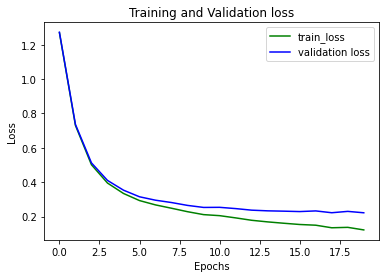

In [64]:

loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Third Run : Let's train the model**

In [65]:
# Train and Test model
isittraining = True
acc_test = tf.keras.metrics.Mean('test_acc')

seeds = np.random.randint(12,45,3)
test_accuracy = []

# for i in seeds:
  # Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)
# print('Trial on random seed:',i)
model.fit_fc(train_dataset, val_dataset, optimizer, isittraining, num_epochs=20, 
          early_stopping_rounds=2, verbose=1, train_from_scratch=True)

# Compute the loss on the eval data after one epoch
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()


Train loss at epoch 1:  0.5705997
Train Acc at epoch 1:  0.8601639
Eval loss at epoch 1:  0.5803009
Eval Acc at epoch 1:  0.8598454
Train loss at epoch 2:  0.3848209
Train Acc at epoch 2:  0.86650544
Eval loss at epoch 2:  0.4001526
Eval Acc at epoch 2:  0.87189204
Train loss at epoch 3:  0.31534705
Train Acc at epoch 3:  0.87697095
Eval loss at epoch 3:  0.33559278
Eval Acc at epoch 3:  0.8813884
Train loss at epoch 4:  0.27905273
Train Acc at epoch 4:  0.885123
Eval loss at epoch 4:  0.30615917
Eval Acc at epoch 4:  0.88837373
Train loss at epoch 5:  0.25345364
Train Acc at epoch 5:  0.8911967
Eval loss at epoch 5:  0.28588325
Eval Acc at epoch 5:  0.8937347
Train loss at epoch 6:  0.23184039
Train Acc at epoch 6:  0.8961512
Eval loss at epoch 6:  0.26992777
Eval Acc at epoch 6:  0.89842474
Train loss at epoch 7:  0.2148475
Train Acc at epoch 7:  0.90047026
Eval loss at epoch 7:  0.2590698
Eval Acc at epoch 7:  0.9024523
Train loss at epoch 8:  0.20560348
Train Acc at epoch 8:  0.904

**Let's test the model**

In [66]:
isittraining = False
for step, (images, target) in enumerate(test_dataset):
  loss = model.loss_fn(images, target, isittraining)
  accuracy = model.compute_accuracy(images,target,isittraining)
  acc_test(accuracy)
  test_accuracy.append(acc_test.result().numpy())

  acc_test.reset_states()

In [67]:
test_mean = np.mean(test_accuracy)

In [68]:
test_mean

0.9288417

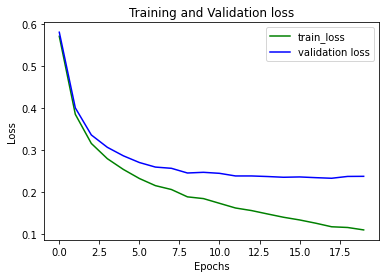

In [69]:

loss_train = model.history['train_loss']
loss_val = model.history['eval_loss']
epochs = range(len(model.history['eval_loss']))
plt.plot(epochs, loss_train, 'g', label='train_loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()